In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("phik").setLevel(logging.ERROR)

# Análisis de Fairness

Modelo final: Random Forest

In [163]:
df = pd.read_csv('../data/processed.csv')
features = df.columns.drop('Survived')

Y = df["Survived"]
X = df.drop(columns=["Survived"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
b_p = [100, 7, 2, 2, 'sqrt']

model = RandomForestClassifier(
    n_estimators=b_p[0],
    max_depth=b_p[1],
    min_samples_split=b_p[2],
    min_samples_leaf=b_p[3],
    max_features=b_p[4],
    random_state=42)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] 

In [164]:
df_ = X_test.copy()
df_['y_true'] = Y_test
df_['y_pred'] = model.predict(X_test)
df_['y_proba'] = model.predict_proba(X_test)[:, 1]

In [165]:
df_['Sex_female'] = np.logical_not(df['Sex_male']).astype(int)
df_['Pclass_1'] = np.logical_not(df[['Pclass_2','Pclass_3']].sum(axis=1)).astype(int)

df_['Female_C1'] = df_['Sex_female']*df_['Pclass_1']
df_['Male_C3'] = df_['Sex_male']*df_['Pclass_3']

Métricas de Fairness por Grupo

In [166]:
def group_metrics(df,group_labels):
    
    results = []
    for g in group_labels:
        df_ = df[df[g]==1]
        cm = confusion_matrix(df_['y_true'].values, df_['y_pred'].values)
        #print(cm)
        tn, fp, fn, tp = cm.ravel()

        TPR = tp / (tp + fn) if (tp+fn) > 0 else 0
        FPR = fp / (fp + tn) if (fp+tn) > 0 else 0
        Precision = tp / (tp + fp) if (tp+fp) > 0 else 0
        DemParity = (tp + fp) / len(df_['y_true'].values)

        results.append({
            "Grupo": g,
            "TPR": TPR,
            "FPR": FPR,
            "Precision": Precision,
            "Dem.Parity": DemParity})
    
    results = pd.DataFrame(results).sort_values(by='Grupo')
    return results

group_labels = ['Sex_male','Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3']
fairness = group_metrics(df_,group_labels)
fairness['Grupo'] = ['1ra Clase','2da Clase', '3ra Clase','Mujeres','Hombres']
fairness.set_index('Grupo',drop=True, inplace=True)
fairness

,TPR,FPR,Precision,Dem.Parity
Grupo,,,,
1ra Clase,0.756757,0.125000,0.933333,0.566038
2da Clase,0.928571,0.263158,0.722222,0.545455
3ra Clase,0.521739,0.100000,0.631579,0.204301
Mujeres,0.903846,0.588235,0.824561,0.826087
Hombres,0.272727,0.045455,0.600000,0.090909


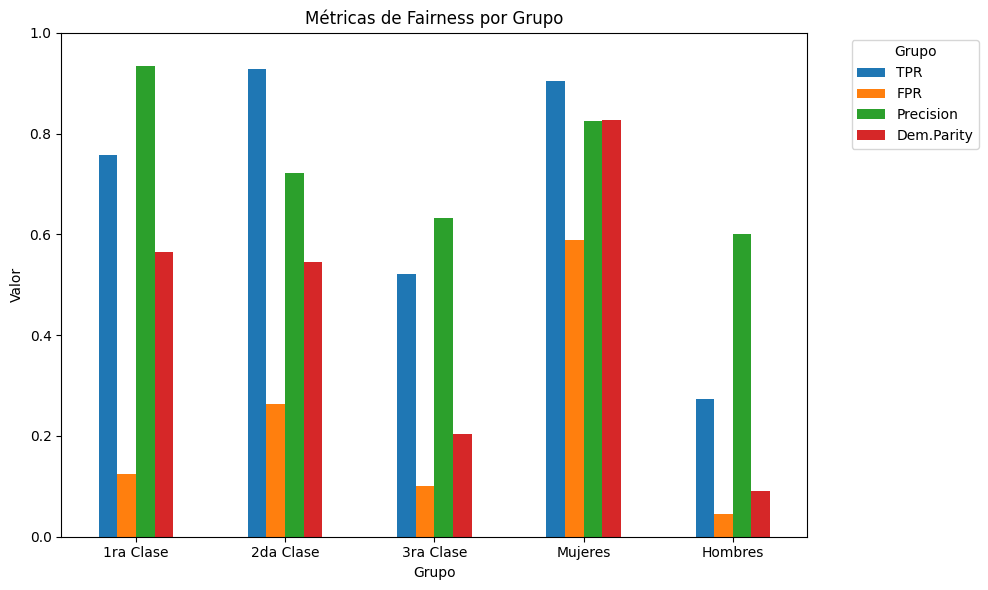

In [167]:
fairness.plot(kind='bar', figsize=(10,6))
plt.title('Métricas de Fairness por Grupo')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Grupo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [168]:
fairness_inter = group_metrics(df_,['Female_C1','Male_C3'])
fairness_inter['Grupo'] = ['Mujeres 1ra Clase','Hombres 3ra Clase']
fairness_inter.set_index('Grupo',drop=True, inplace=True)
fairness_inter
# No sé por qué da error

ValueError: not enough values to unpack (expected 4, got 1)

In [169]:
df_x = df_[df_['Male_C3']==1]
cm = confusion_matrix(df_x['y_true'].values, df_x['y_pred'].values)
cm
tn, fp, fn, tp = cm.ravel()
# ???????